In [1]:
%matplotlib inline
import pandas as np
import xarray as xr
import numpy as np
import os
import sys
sys.path.insert(0, '/home/catherinej/BarrierIslandBreachProject/code/utilities')
import waveforms
import pygmt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

In [3]:
def visualize_bay_division(fg):
    data = xr.open_dataset(fg)
    df = data.eta.to_dataframe()

    # Filter by bay/ocean location
    locs = [waveforms.gauges_in_bay(x,y) for x,y in zip(df.index.get_level_values(1),
                                                        df.index.get_level_values(0))]
    df['locations'] = locs
    bay_indx = df.index[df['locations'] == 'bay']
    bay_locations = df.loc[bay_indx].reset_index()

    west_pt = df.index.get_level_values(1).min()
    east_pt = df.index.get_level_values(1).max()
    central_pt = (east_pt - west_pt) / 3

    return west_pt, east_pt, central_pt, bay_locations, bay_indx


def save_selected_surge_locs(fg_files, bay_indx, datapath='./'):

    # select 3 random locations using these for consistency, can change
    widx = [105695, 528355, 56117]
    eidx = [1356806, 552806, 1068642]
    cidx = [439911, 1147411, 1249304]

    # Load all the others, sort, get the individual locations saved
    w = []
    e = []
    c = []
    for file in fg_files:
        ds = xr.open_dataset(file)
        df = ds.eta.to_dataframe().rename(
            columns={'eta': file.split('/')[-1].rsplit('_', 1)[0]})

        bay = df.loc[bay_indx]

        w.append(bay.iloc[widx])
        c.append(bay.iloc[cidx])
        e.append(bay.iloc[eidx])

    west = pd.concat(w, axis=1)
    east = pd.concat(e, axis=1)
    central = pd.concat(c, axis=1)

    if not os.path.exists(datapath):
        os.mkdir(datapath)
    west.T.to_pickle(os.path.join(datapath, 'west_fgmax_points.pkl.gz'),
                     compression='gzip')
    east.T.to_pickle(os.path.join(datapath, 'east_fgmax_pts.pkl.gz'),
                     compression='gzip')
    central.T.to_pickle(os.path.join(datapath, 'central_fgmax_pts.pkl.gz'),
                        compression='gzip')

def bay_section_max_surge(fg_files, bay_indx, west_pt, east_pt, central_pt, datapath='./'):
    w = []
    c = []
    e = []

    for file in fg_files:
        ds = xr.open_dataset(file)
        df = ds.eta.to_dataframe().rename(
            columns={'eta': file.split('/')[-1].rsplit('_', 1)[0]})

        bay_locations = df.loc[bay_indx].reset_index()
        wbay = bay_locations[bay_locations.lon.between(west_pt, west_pt + central_pt)]
        cbay = bay_locations[bay_locations.lon.between(west_pt + central_pt, east_pt - central_pt)]
        ebay = bay_locations[bay_locations.lon.between(east_pt - central_pt, east_pt)]

        w.append(wbay.max())
        c.append(cbay.max())
        e.append(ebay.max())

    west = pd.concat(w, axis=1)
    east = pd.concat(e, axis=1)
    central = pd.concat(c, axis=1)

    # Save for easy replotting
    west.T.to_pickle(os.path.join(datapath, 'west_fg_max.pkl.gz'),
                     compression='gzip')
    east.T.to_pickle(os.path.join(datapath, 'east_fg_max.pkl.gz'),
                     compression='gzip')
    central.T.to_pickle(os.path.join(datapath, 'central_fg_max.pkl.gz'),
                        compression='gzip')
path = '/home/catherinej/BarrierIslandBreachProject/data/raw/fg_nc_300k_radius/'
fg_files = [os.path.join(path, x) for x in os.listdir(path) if '.ipynb' not in x]
west, east, central, bay_locations, bay_indx = visualize_bay_division(fg_files[0])
save_selected_surge_locs(fg_files, bay_indx)
bay_section_max_surge(fg_files, bay_indx, west, east, central)
total_bay_max_surge(fg_files, bay_indx)

NameError: name 'total_bay_max_surge' is not defined

In [1]:
import os
import pandas as pd
import xarray as xr

def bay_section_max_surge(fg_files, bay_indx, west_pt, east_pt, central_pt, datapath='./'):
    # Initialize lists to store max values for each region
    w_max, c_max, e_max = [], [], []

    # Precompute the central boundaries
    west_central_boundary = west_pt + central_pt
    east_central_boundary = east_pt - central_pt

    for file in fg_files:
        # Open dataset and convert to DataFrame
        ds = xr.open_dataset(file)
        df = ds.eta.to_dataframe().rename(columns={'eta': file.split('/')[-1].rsplit('_', 1)[0]})

        # Select bay locations once
        bay_locations = df.loc[bay_indx]

        # Filter for each section
        w_max.append(bay_locations[bay_locations.lon.between(west_pt, west_central_boundary)].max())
        c_max.append(bay_locations[bay_locations.lon.between(west_central_boundary, east_central_boundary)].max())
        e_max.append(bay_locations[bay_locations.lon.between(east_central_boundary, east_pt)].max())

    # Concatenate the max values and transpose for saving
    west = pd.concat(w_max, axis=1).T
    central = pd.concat(c_max, axis=1).T
    east = pd.concat(e_max, axis=1).T

    # Save the results with compression
    west.to_pickle(os.path.join(datapath, 'west_fg_max.pkl.gz'), compression='gzip')
    central.to_pickle(os.path.join(datapath, 'central_fg_max.pkl.gz'), compression='gzip')
    east.to_pickle(os.path.join(datapath, 'east_fg_max.pkl.gz'), compression='gzip')


In [2]:
def hist_nine(x, y, z, k,l, m, bins, ax):
    from matplotlib.ticker import FormatStrFormatter
    from matplotlib.ticker import LinearLocator
    ax.hist(x['data'], bins, weights=x['weight'], color=x['color'], histtype='stepfilled', alpha=0.2, label=x['name'])
    ax.hist(x['data'], bins, weights=x['weight'], color=x['color'], histtype='step', alpha=0.7)
    
    ax.hist(y['data'], bins, weights=y['weight'], color=y['color'], histtype='stepfilled', alpha=0.2, label=y['name'])
    ax.hist(y['data'], bins, weights=y['weight'], color=y['color'], histtype='step', alpha=0.7)
    
    ax.hist(z['data'], bins, weights=z['weight'], color=z['color'], histtype='stepfilled', alpha=0.2, label=z['name'])
    ax.hist(z['data'], bins, weights=z['weight'], color=z['color'], histtype='step', alpha=0.7)
    
    ax.hist(k['data'], bins, weights=k['weight'], color=k['color'], histtype='stepfilled', alpha=0.2, label=k['name'])
    ax.hist(k['data'], bins, weights=k['weight'], color=k['color'], histtype='step', alpha=0.7)
    
    
    ax.hist(l['data'], bins, weights=l['weight'], color=l['color'], histtype='stepfilled', alpha=0.2, label=l['name'])
    ax.hist(l['data'], bins, weights=l['weight'], color=l['color'], histtype='step', alpha=0.7)

    ax.hist(m['data'], bins, weights=m['weight'], color=m['color'], histtype='stepfilled', alpha=0.2, label=m['name'])
    ax.hist(m['data'], bins, weights=m['weight'], color=m['color'], histtype='step', alpha=0.7)
    
    ax.xaxis.set_major_locator(LinearLocator(6))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    

In [3]:
west = pd.read_pickle('../data/processed/west_fgmax_points.pkl.gz')
central = pd.read_pickle('../data/processed/central_fgmax_pts.pkl.gz')
east = pd.read_pickle('../data/processed/east_fgmax_pts.pkl.gz')

<Figure size 2400x699 with 0 Axes>

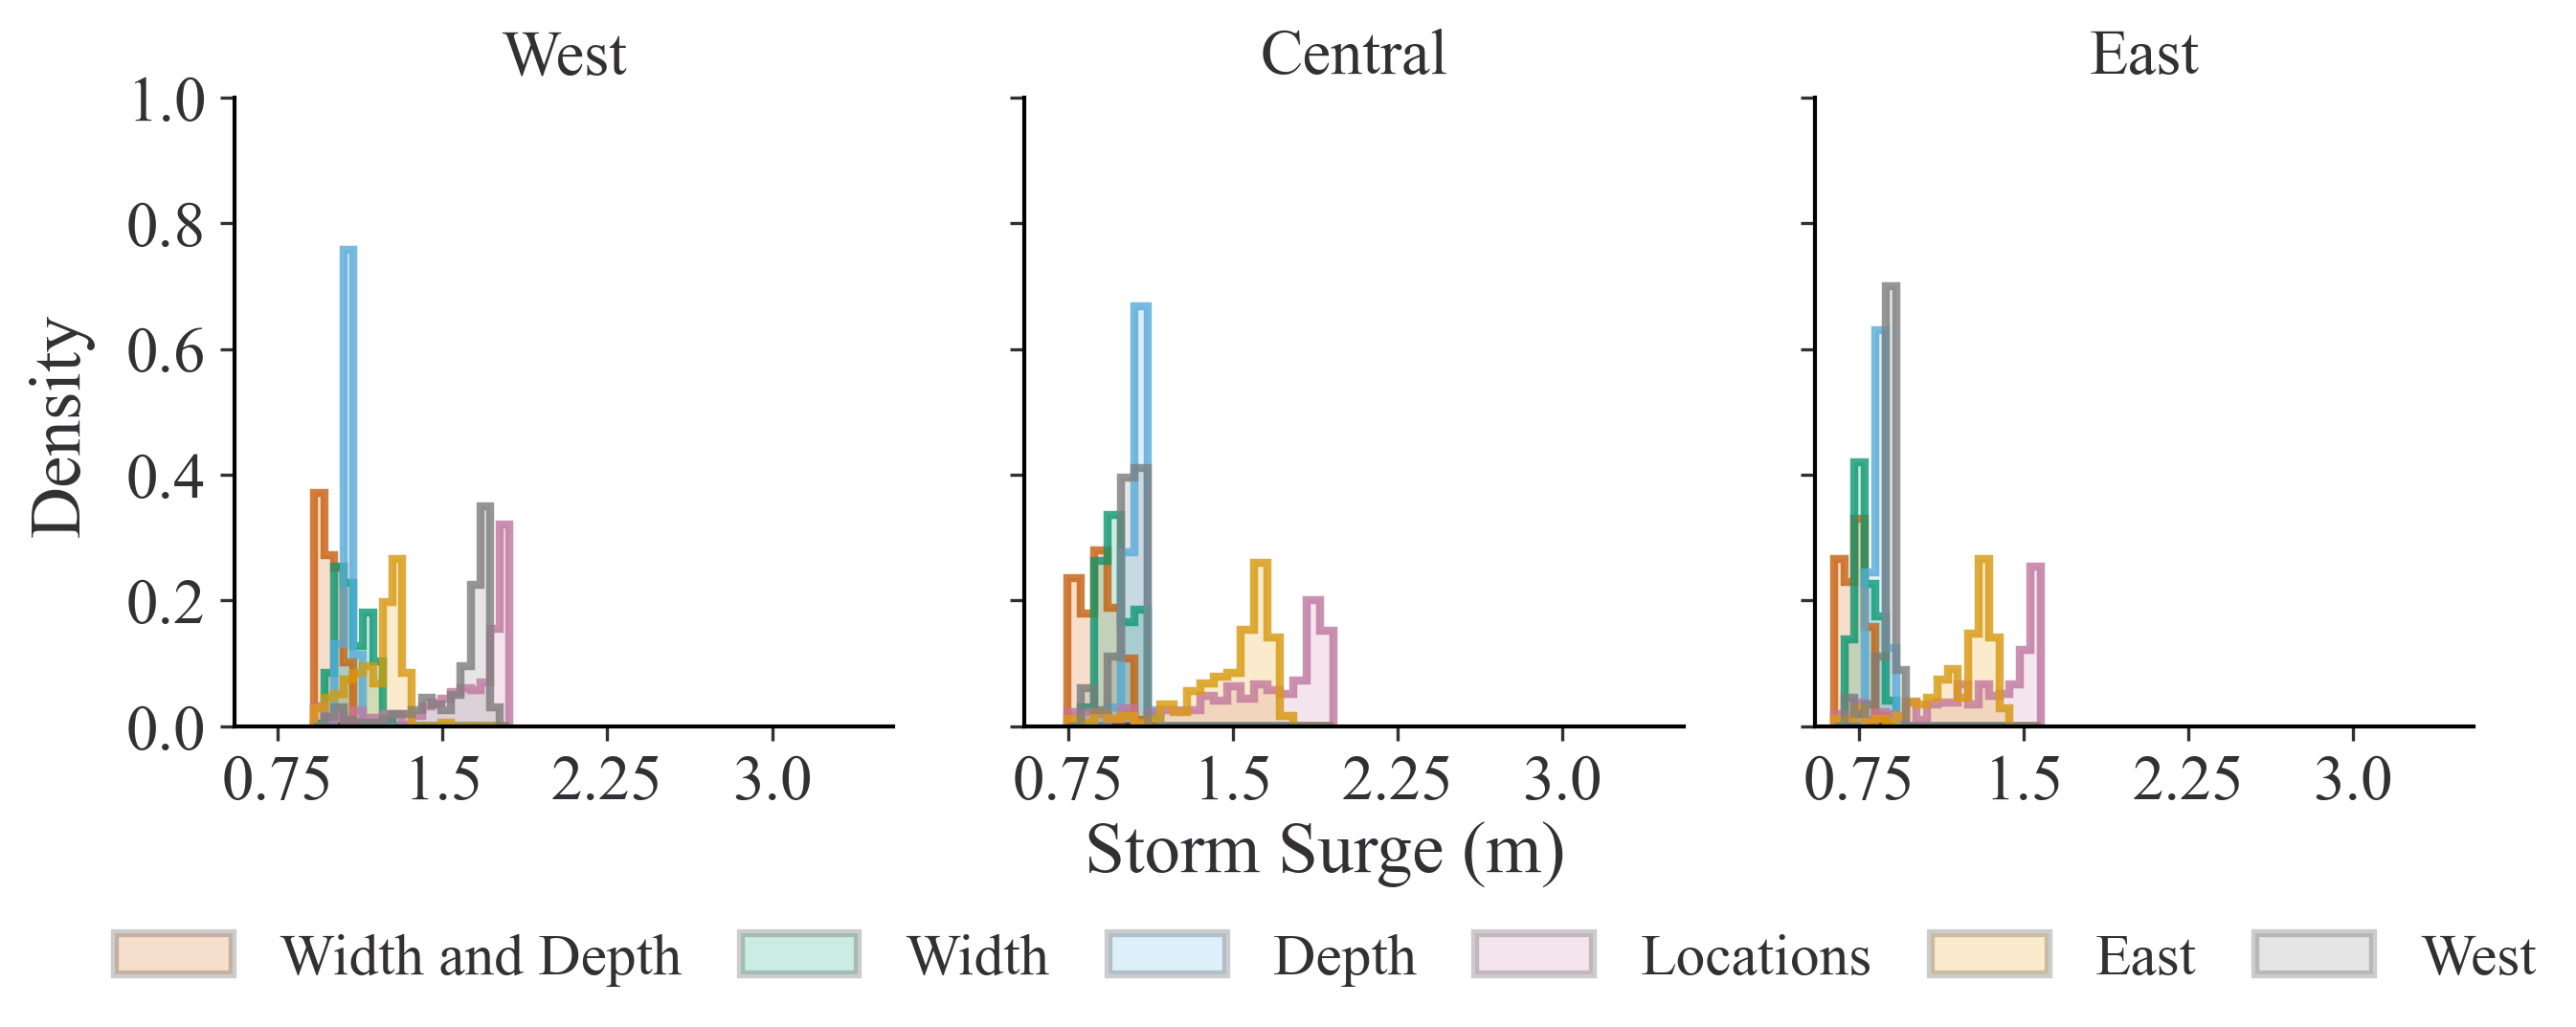

In [16]:
import matplotlib.pyplot as plt
plt.style.use('./mystyle.mplstyle')

west = pd.read_pickle('../data/processed/west_fgmax_points.pkl.gz')
central = pd.read_pickle('../data/processed/central_fgmax_pts.pkl.gz')
east = pd.read_pickle('../data/processed/east_fgmax_pts.pkl.gz')

def fg_max_prep(west, central, east):
    central = central.T.reset_index().iloc[1]
    west = west.T.reset_index().iloc[1]
    east = east.T.reset_index().iloc[1]
    w = west.drop(['lat', 'lon'])
    c = central.drop(['lat', 'lon'])
    e = east.drop(['lat', 'lon'])

    return w, c, e
# mpl.use('pgf')
# Plot width vs depth histograms on same figure
# subsets = [central[central.columns[1]], west[west.columns[1]], east[east.columns[1]]]
w, c, e = fg_max_prep(west, central, east)
subsets = [w, c, e]
names = ['west', 'central', 'east']

plt.figure(figsize=(8,2.33))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

plt.rcParams.update({'font.size': 16*1.95})  # Fig. 5

fig, axes = plt.subplots(1,3,figsize=(10,3), sharey=True)

for idx, subset in enumerate(subsets):
  
    ax = axes[idx]
    ax.set_title(names[idx].capitalize())
    x = {}
    y = {}
    z = {}
    k = {}
    l = {}
    m = {}
#     wd = subset.T[subset.T.index.str.contains('dw')]
#     rall = subset.T[subset.T.index.str.contains('loc')]
#     depth = subset.T[~subset.T.index.str.contains('|'.join(['w', 'loc','east', 'west']))]
#     width = subset.T[~subset.T.index.str.contains('|'.join(['d', 'loc', 'east', 'west']))]
#     east = subset.T[subset.T.index.str.contains('east')]
#     west = subset.T[subset.T.index.str.contains('west')]
    
#     east_weights = np.ones_like(east) / len(east)
#     west_weights = np.ones_like(west) / len(west)
#     wweights = np.ones_like(width)/len(width)
#     dweights = np.ones_like(depth)/len(depth)
#     rweights = np.ones_like(rall)/len(rall)
#     wd_weights = np.ones_like(wd)/len(wd)
    wd = subset.T[subset.T.index.str.contains('dw')]
    wd = wd.values[~np.isnan(wd.values)]
    rall = subset.T[subset.T.index.str.contains('loc')]
    rall = rall.values[~np.isnan(rall.values)]
    depth = subset.T[~subset.T.index.str.contains('|'.join(['w', 'loc', 'east']))]
    d = depth.values[~np.isnan(depth.values)]
    width = subset.T[~subset.T.index.str.contains('|'.join(['d', 'loc', 'west', 'east']))]
    w = width.values[~np.isnan(width.values)]
    east = subset.T[subset.T.index.str.contains('east')]
    e = east.values[~np.isnan(east.values)]
    west = subset.T[subset.T.index.str.contains('west')]
    west = west.values[~np.isnan(west.values)]
    
    wweights = np.ones_like(w) / len(w)
    dweights = np.ones_like(d) / len(d)
    rweights = np.ones_like(rall) / len(rall)
    wd_weights = np.ones_like(wd) / len(wd)
    eweights = np.ones_like(e)/len(e)
    west_weights = np.ones_like(west)/len(west)
    bins = np.histogram(np.hstack((wd, w, d, rall, e, west)), bins=20)[1]
    # bins=np.histogram(np.hstack((wd, width, depth, rall, east, west)), bins=20)[1]
    x = {'data': wd,
         'weight': wd_weights,
         'color': 	'#D55E00',
         'hatch': '/',
         'name': 'Width and Depth'}
    y = {'data': w,
         'weight': wweights,
         'color': '#009E73',
         'hatch': '//',
         'name': 'Width'}
    z = {'data': d,
         'weight': dweights,
         'color': '#56B4E9',
         'hatch': '-',
         'name': 'Depth'}
    k = {'data': rall,
         'weight': rweights,
         'color': '#CC79A7',
         'hatch': '|',
         'name': 'Locations'}
    l = {'data' : e,
         'weight': eweights,
         'color': '#E69F00',
         'hatch': '+',
         'name': 'East'}
    m = {'data': west,
         'weight': west_weights,
         'color': 'grey',
         'hatch': '--',
         'name': 'West'}

    hist_nine(x,y,z,k,l,m, bins, ax)
    plt.setp(ax,  ylim=(0.0, 1.0), xlim=(0.55, 3.55)
    )
    ax.set_xticks([0.75, 1.5, 2.25, 3.0])
    ax.set_xticklabels(['0.75', '1.5', '2.25', '3.0'])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
# Add a legend below the x-axis
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=6, fontsize=14/.95, frameon=False)

# Adjust spacing to accommodate the legend
fig.subplots_adjust(bottom=0.25)
plt.title = names[idx]

fig.text(0.5, 0.0001, 'Storm Surge (m)', ha='center', va='center', fontsize=18)
fig.text(0.06, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=18)
fig.subplots_adjust(bottom=0.15, left=0.12)

plt.savefig(f'fig5.pdf', bbox_inches='tight')
plt.show()


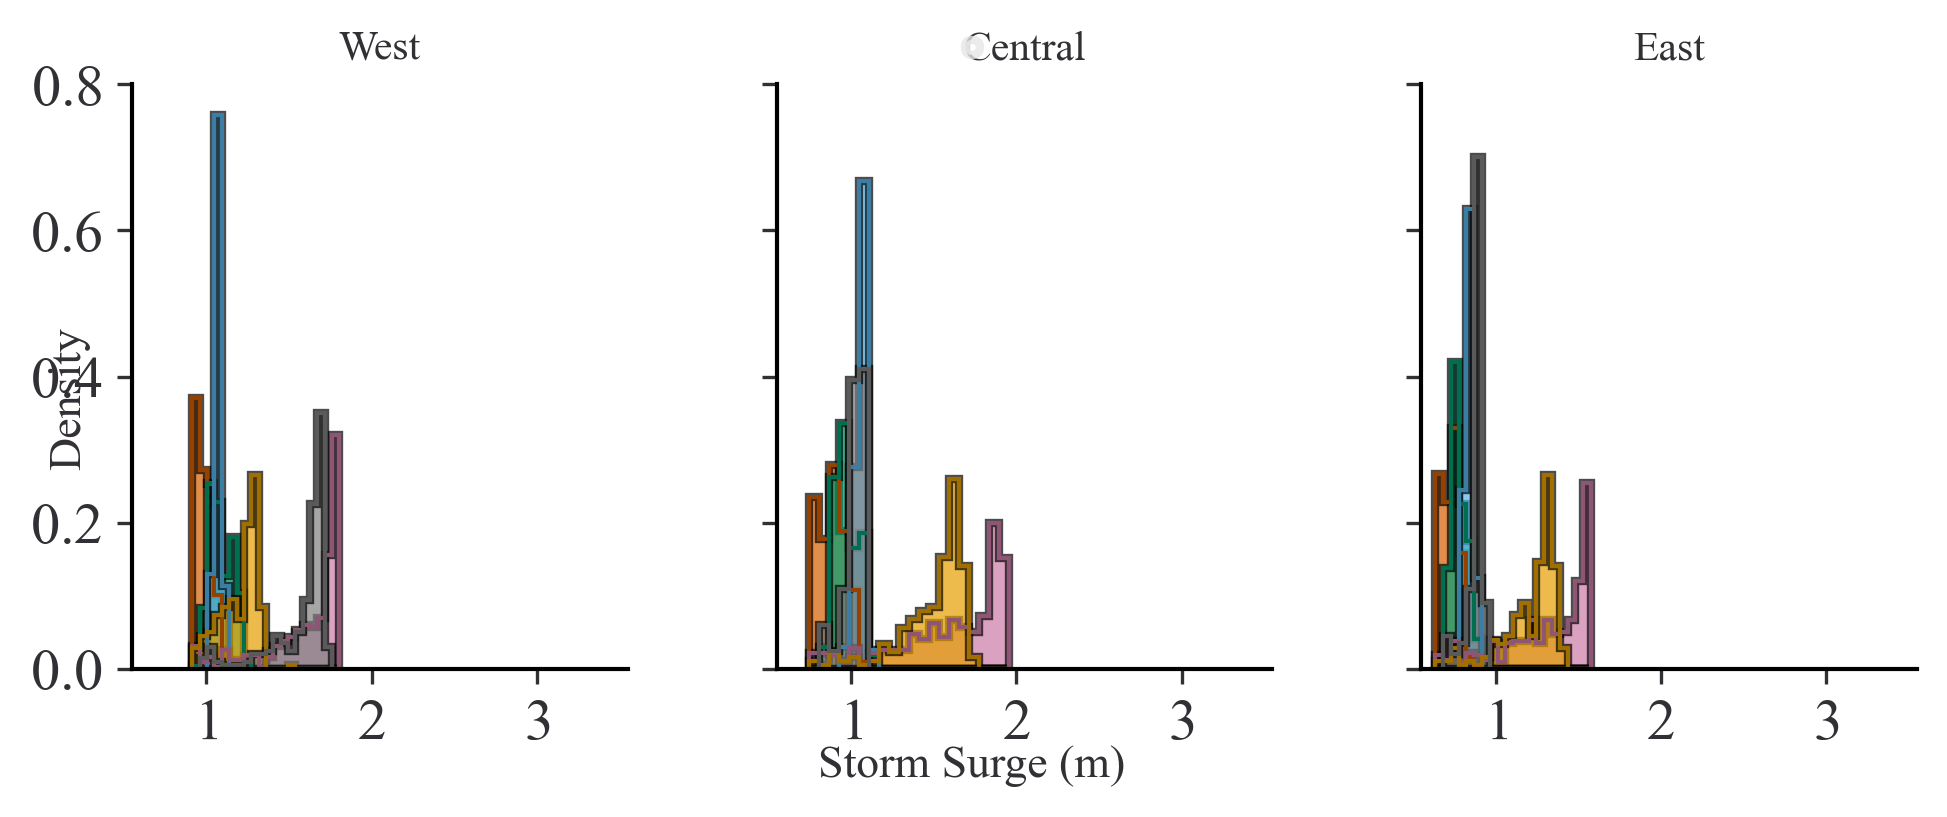

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Function to darken a color slightly
def darken_color(color, factor=0.7):
    rgb = mcolors.to_rgb(color)
    return mcolors.to_hex(tuple([c * factor for c in rgb]))

# Figure size and axes setup
fig, axes = plt.subplots(1, 3, figsize=(7, 3), sharey=True)  # Keep width 7", reduce height
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.85, wspace=0.3)

# Plotting loop
for idx, subset in enumerate(subsets):
    ax = axes[idx]
    ax.set_title(names[idx].capitalize(), fontsize=10)

    # Extract and clean data
    wd = subset.loc[subset.index.str.contains('dw')].dropna().values.flatten()
    rall = subset.loc[subset.index.str.contains('loc')].dropna().values.flatten()
    depth = subset.loc[~subset.index.str.contains('|'.join(['w', 'loc', 'east']))].dropna().values.flatten()
    width = subset.loc[~subset.index.str.contains('|'.join(['d', 'loc', 'west', 'east']))].dropna().values.flatten()
    east = subset.loc[subset.index.str.contains('east')].dropna().values.flatten()
    west = subset.loc[subset.index.str.contains('west')].dropna().values.flatten()

    # Define weights
    def weights(data): return np.ones_like(data) / len(data)
    bins = np.histogram(np.hstack((wd, width, depth, rall, east, west)), bins=20)[1]

    # Define histogram settings
    hist_data = [
        {'data': wd, 'color': '#D55E00', 'name': 'Width and Depth'},
        {'data': width, 'color': '#009E73', 'name': 'Width'},
        {'data': depth, 'color': '#56B4E9', 'name': 'Depth'},
        {'data': rall, 'color': '#CC79A7', 'name': 'Locations'},
        {'data': east, 'color': '#E69F00', 'name': 'East'},
        {'data': west, 'color': 'grey', 'name': 'West'},
    ]

    # Plot filled histograms with slightly darker outlines
    for h in hist_data:
        outline_color = darken_color(h['color'])
        ax.hist(h['data'], bins=bins, weights=weights(h['data']),
                color=h['color'], alpha=0.7, histtype='stepfilled', edgecolor=None)
        ax.hist(h['data'], bins=bins, weights=weights(h['data']),
                color=outline_color, histtype='step', linewidth=1.0)

    # Set limits and labels
    ax.set_ylim(0.0, 0.8)
    ax.set_xlim(0.55, 3.55)

# Shared global labels
fig.text(0.5, 0.08, 'Storm Surge (m)', ha='center', fontsize=11)
fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical', fontsize=11)

# Add a legend in a clean position
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.92), fontsize=9)

# Save and show
plt.savefig('fig5_v2.pdf', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 2400x699 with 0 Axes>

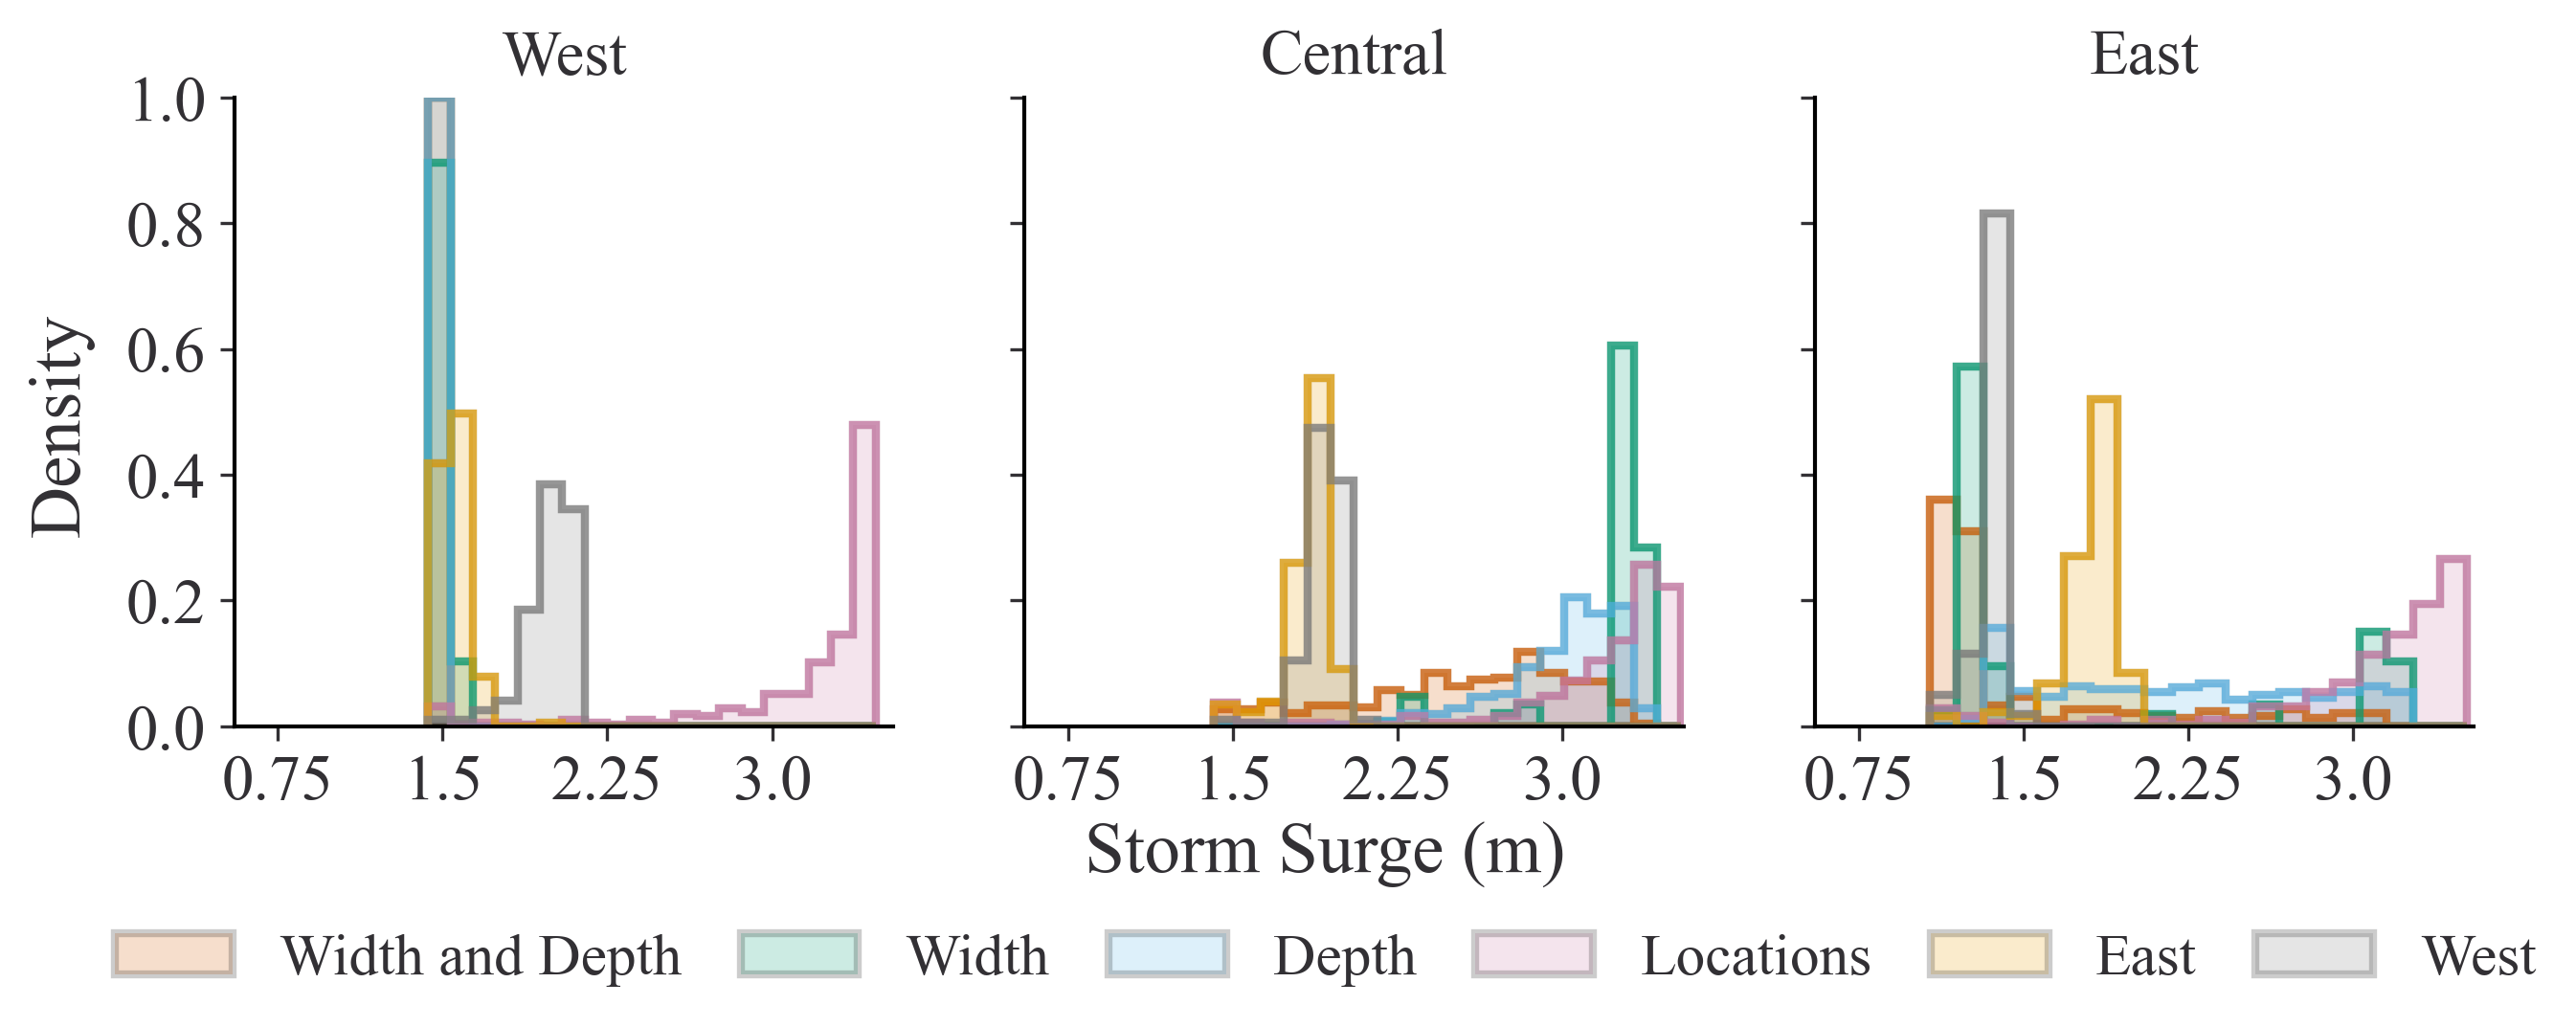

In [17]:
west = pd.read_pickle('../data/processed/west_fg_max.pkl.gz')
central = pd.read_pickle('../data/processed/central_fg_max.pkl.gz')
east = pd.read_pickle('../data/processed/east_fg_max.pkl.gz')
import matplotlib.pyplot as plt
plt.style.use('./mystyle.mplstyle')
def fg_max_prep(west, central, east):
    w = west.drop(['lat', 'lon'], axis=1)
    c = central.drop(['lat', 'lon'], axis=1)
    e = east.drop(['lat', 'lon'], axis=1)

    return w, c, e
# mpl.use('pgf')
# Plot width vs depth histograms on same figure
# subsets = [central[central.columns[1]], west[west.columns[1]], east[east.columns[1]]]
w, c, e = fg_max_prep(west, central, east)
subsets = [w, c, e]
names = ['west', 'central', 'east']

plt.figure(figsize=(8,2.33))
plt.subplots_adjust(hspace=0.25, wspace=0.25)


plt.rcParams.update({'font.size': 16*1.95})  # Fig. 5

fig, axes = plt.subplots(1,3,figsize=(10,3), sharey=True)

for idx, subset in enumerate(subsets):
  
    ax = axes[idx]
    ax.set_title(names[idx].capitalize())
    x = {}
    y = {}
    z = {}
    k = {}
    l = {}
    m = {}
#     wd = subset.T[subset.T.index.str.contains('dw')]
#     rall = subset.T[subset.T.index.str.contains('loc')]
#     depth = subset.T[~subset.T.index.str.contains('|'.join(['w', 'loc','east', 'west']))]
#     width = subset.T[~subset.T.index.str.contains('|'.join(['d', 'loc', 'east', 'west']))]
#     east = subset.T[subset.T.index.str.contains('east')]
#     west = subset.T[subset.T.index.str.contains('west')]
    
#     east_weights = np.ones_like(east) / len(east)
#     west_weights = np.ones_like(west) / len(west)
#     wweights = np.ones_like(width)/len(width)
#     dweights = np.ones_like(depth)/len(depth)
#     rweights = np.ones_like(rall)/len(rall)
#     wd_weights = np.ones_like(wd)/len(wd)
    wd = subset.T[subset.T.index.str.contains('dw')]
    wd = wd.values[~np.isnan(wd.values)]
    rall = subset.T[subset.T.index.str.contains('loc')]
    rall = rall.values[~np.isnan(rall.values)]
    depth = subset.T[~subset.T.index.str.contains('|'.join(['w', 'loc', 'east']))]
    d = depth.values[~np.isnan(depth.values)]
    width = subset.T[~subset.T.index.str.contains('|'.join(['d', 'loc', 'west', 'east']))]
    w = width.values[~np.isnan(width.values)]
    east = subset.T[subset.T.index.str.contains('east')]
    e = east.values[~np.isnan(east.values)]
    west = subset.T[subset.T.index.str.contains('west')]
    west = west.values[~np.isnan(west.values)]
    
    wweights = np.ones_like(w) / len(w)
    dweights = np.ones_like(d) / len(d)
    rweights = np.ones_like(rall) / len(rall)
    wd_weights = np.ones_like(wd) / len(wd)
    eweights = np.ones_like(e)/len(e)
    west_weights = np.ones_like(west)/len(west)
    bins = np.histogram(np.hstack((wd, w, d, rall, e, west)), bins=20)[1]
    # bins=np.histogram(np.hstack((wd, width, depth, rall, east, west)), bins=20)[1]
    x = {'data': wd,
         'weight': wd_weights,
         'color': 	'#D55E00',
         'name': 'Width and Depth'}
    y = {'data': w,
         'weight': wweights,
         'color': '#009E73',
         'name': 'Width'}
    z = {'data': d,
         'weight': dweights,
         'color': '#56B4E9',
         'name': 'Depth'}
    k = {'data': rall,
         'weight': rweights,
         'color': '#CC79A7',
         'name': 'Locations'}
    l = {'data' : e,
         'weight': eweights,
         'color': '#E69F00',
         'name': 'East'}
    m = {'data': west,
         'weight': west_weights,
         'color': 'grey',
         'name': 'West'}

    hist_nine(x,y,z,k,l,m,bins, ax,)
    plt.setp(ax,  ylim=(0.0, 1.0), xlim=(0.55, 3.55)
    )
    ax.set_xticks([0.75, 1.5, 2.25, 3.0])
    ax.set_xticklabels(['0.75', '1.5', '2.25', '3.0'])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
# Add a legend below the x-axis
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=6, fontsize=14/.95, frameon=False)

# Adjust spacing to accommodate the legend
fig.subplots_adjust(bottom=0.25)

plt.title = names[idx]

fig.text(0.5, 0.0001, 'Storm Surge (m)', ha='center', va='center', fontsize=18)
fig.text(0.06, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=18)
fig.subplots_adjust(bottom=0.15, left=0.12)

plt.savefig(f'fig6.pdf', bbox_inches='tight')
plt.show()


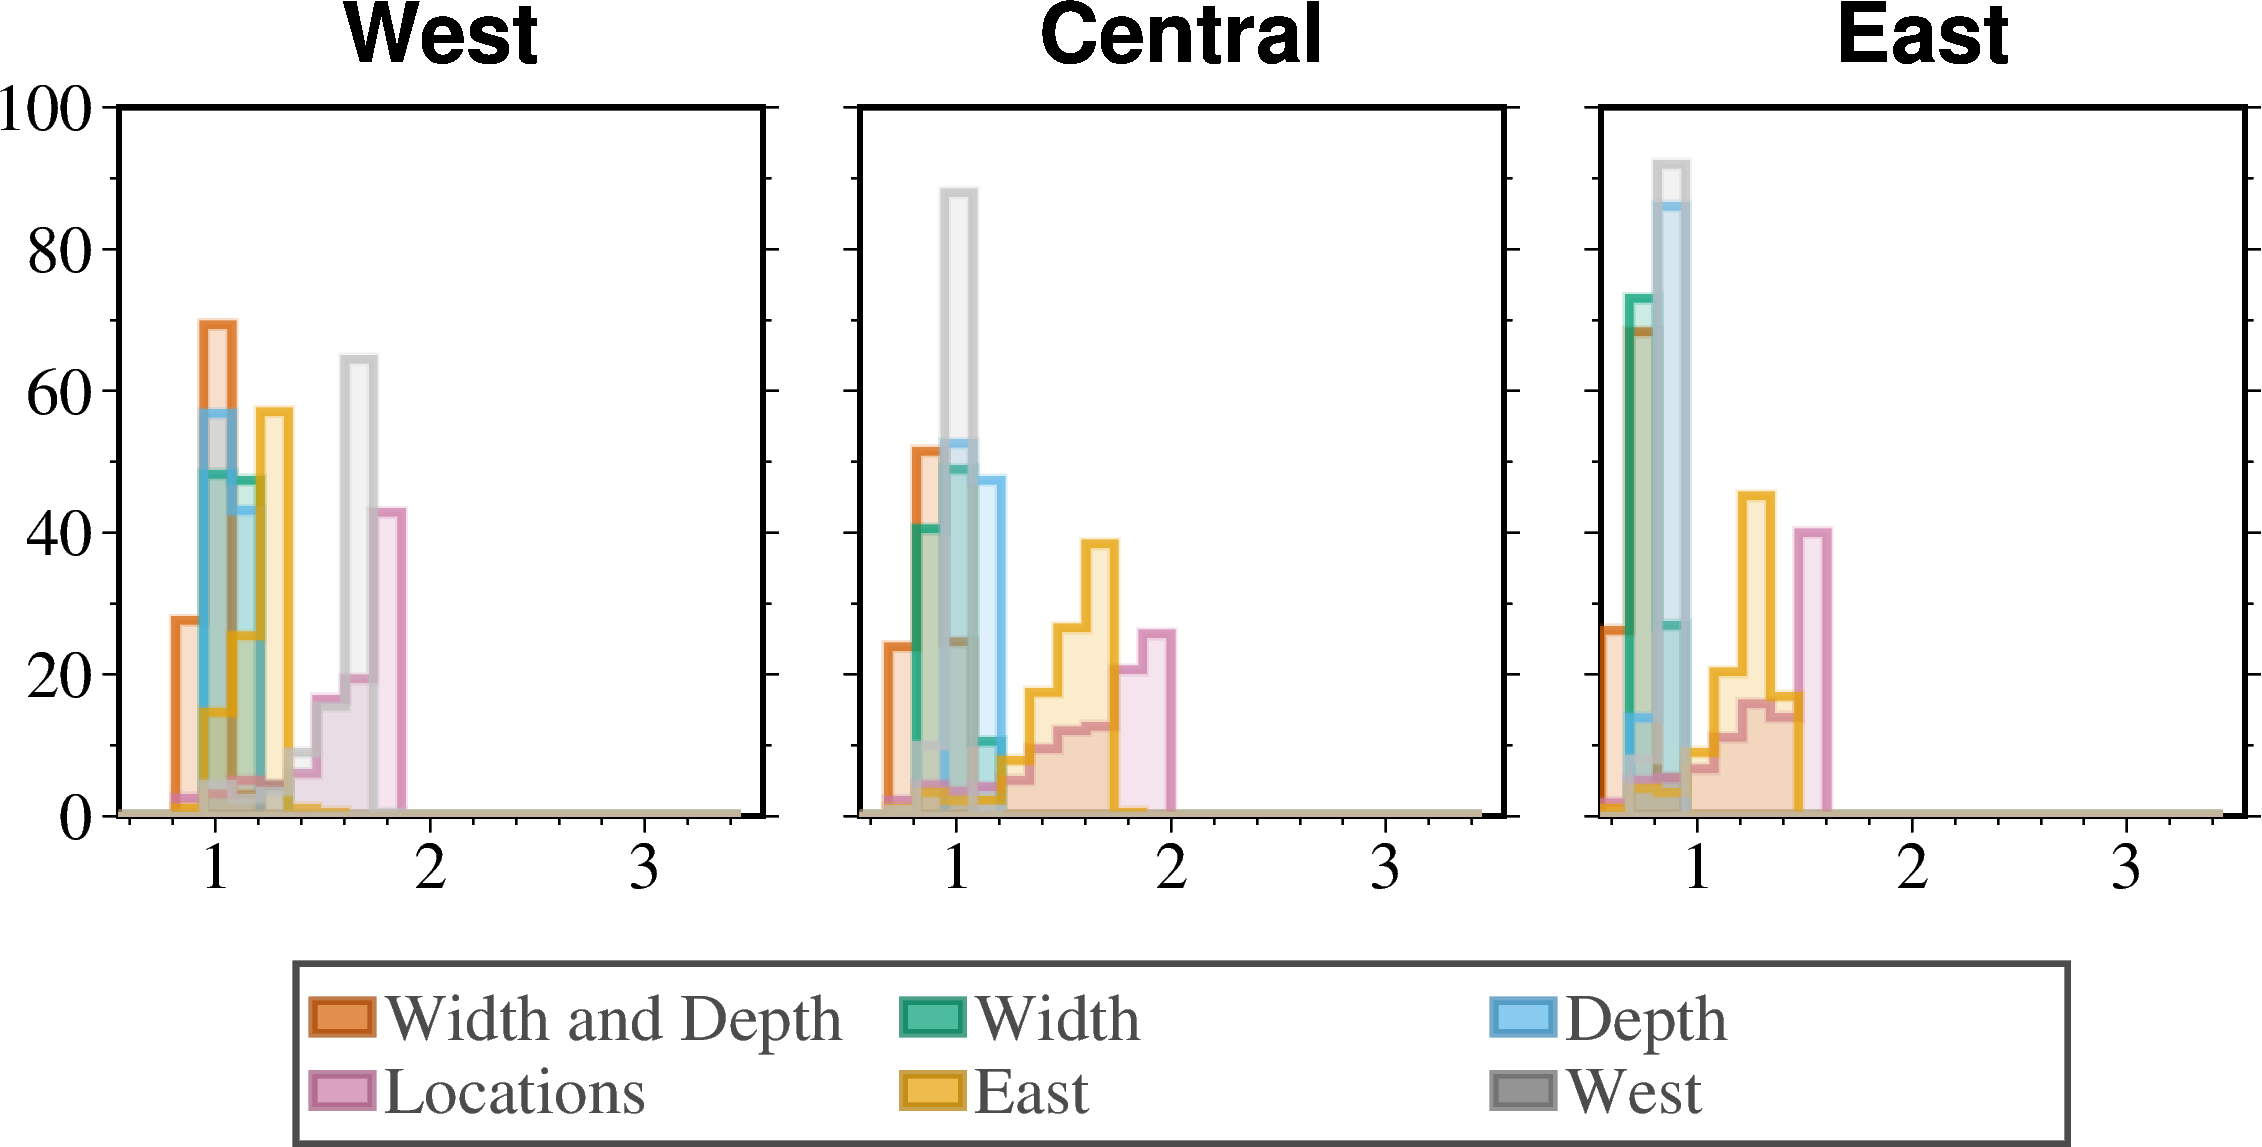

In [329]:
import pygmt
import pandas as pd
import numpy as np
import yaml

# Function to prepare data (adapted from your fg_max_prep function)
def fg_max_prep(west, central, east):
    central = central.T.reset_index().iloc[1]
    west = west.T.reset_index().iloc[1]
    east = east.T.reset_index().iloc[1]
    w = west.drop(['lat', 'lon'])
    c = central.drop(['lat', 'lon'])
    e = east.drop(['lat', 'lon'])
    return w, c, e

# Load data
west = pd.read_pickle('../data/processed/west_fgmax_points.pkl.gz')
central = pd.read_pickle('../data/processed/central_fgmax_pts.pkl.gz')
east = pd.read_pickle('../data/processed/east_fgmax_pts.pkl.gz')

# Prepare data
w, c, e = fg_max_prep(west, central, east)
subsets = [w, c, e]
names = ['West', 'Central', 'East']

with open('gmt_config.yml', 'r') as ymlfile:
    map_cfg = yaml.safe_load(ymlfile)
# Define the common region
region = [0.55, 3.55, 0, 1.0]
fig = pygmt.Figure()
with pygmt.config(**map_cfg['region_map']):
    with fig.subplot(nrows=1,ncols=3, figsize=(['18c', '6c']), sharey='l'):
        # Plot each subset
        for idx, subset in enumerate(subsets):
            with fig.set_panel(idx):
                # Process the data
                wd = subset.T[subset.T.index.str.contains('dw')].dropna()
                rall = subset.T[subset.T.index.str.contains('loc')].dropna()
                depth = subset.T[~subset.T.index.str.contains('|'.join(['w', 'loc', 'east']))].dropna()
                width = subset.T[~subset.T.index.str.contains('|'.join(['d', 'loc', 'west', 'east']))].dropna()
                east = subset.T[subset.T.index.str.contains('east')].dropna()
                west = subset.T[subset.T.index.str.contains('west')].dropna()
            
                wweights = np.ones_like(w) / len(w)
                dweights = np.ones_like(d) / len(d)
                rweights = np.ones_like(rall) / len(rall)
                wd_weights = np.ones_like(wd) / len(wd)
                eweights = np.ones_like(e)/len(e)
                west_weights = np.ones_like(west)/len(west)
                
                # Number of bins
                num_bins = 20
                
                bins = np.histogram(np.hstack((wd, w, d, rall, e, west)), bins=20)[1]
                # Convert to PyGMT series
                start = bins[0]
                end = bins[-1]
                inc = bins[1] - bins[0]
                series = f"{start}/{end}/{inc}"
                
                # Plot histograms
                datasets = [
                    (wd, "#D55E00", "Width and Depth"),
                    (width, "#009E73", "Width"),
                    (depth, "#56B4E9", "Depth"),
                    (rall, "#CC79A7", "Locations"),
                    (east, "#E69F00", "East"),
                    (west, "grey", "West"),
                ]
                
                for data, color, label in datasets:
                
                    # Generate weights (example: use uniform weights or other logic)
                    weights = np.ones_like(data) / len(data)  # Normalize weights to sum to 1
            
                            # Combine data and weights into a DataFrame
                    data_with_weights = pd.DataFrame({
                        "data": data,
                        "weights": weights,
                    })
                        # if label in 'wd':
                         #Define region for PyGMT
                    region = [0.55, 3.55, 0, 100]  # Adjust y-axis range if needed
                    with pygmt.config(**map_cfg['region_map']):
                    # Create the PyGMT histogram
                        fig.basemap(region=region, projection='X?', frame=[f"+t{names[idx]}"])
                
                    fig.histogram(
                        data=data_with_weights,
                        series=series,
                        histtype='1+w',
                        projection="X?",
                        fill=color,
                        pen=f"3p,{color},solid",
                        transparency=80,
                        stairs=True,
                        
                        
                          # Use frequency (absolute count)
                    )
                    fig.histogram(
                        data=data_with_weights,
                        series=series,
                        histtype='1+w',
                        projection="X?",
                        pen=f"2p,{color},solid",
                        transparency=30,
                        stairs=True,
                       )
                        # Outline bars like Matplotlib
                          # Use frequency (absolute count)
                    # fig.legend(position='JBC', box=True, panel=1)
    
        # Add legend
           # Add legend below all plots
    fig.legend(
        spec='hist_legend.txt',
        position="JBC+w15.c+o0/1.25",  # Justified Bottom Center
        box=True,
        transparency=30,
        # frame=["+gwhite"],
    )
        
# Add labels
fig.text(x=1.5, y=-0.15, text="Storm Surge (m)", region=region, justify="CM", font="16p")
fig.text(x=0.06, y=0.5, text="Density", region=region, justify="CM", font="16p", angle=90)

# Save and show figure
# fig.savefig("fig5.pdf")
fig.show()
